In [1]:
import os
import urllib.request
import gzip
import numpy as np

def download_and_parse_mnist(file_name, base_url):
    file_path = file_name
    if not os.path.exists(file_path):
        print(f"Downloading {file_name}...")
        urllib.request.urlretrieve(base_url + file_name, file_path)
    
    with gzip.open(file_path, 'rb') as f:
        if "images" in file_name:
            _ = int.from_bytes(f.read(4), 'big')  # magic number
            num_images = int.from_bytes(f.read(4), 'big')
            rows = int.from_bytes(f.read(4), 'big')
            cols = int.from_bytes(f.read(4), 'big')
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
        else:  # labels
            _ = int.from_bytes(f.read(4), 'big')  # magic number
            num_items = int.from_bytes(f.read(4), 'big')
            data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

# Load all parts
base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
train_images = download_and_parse_mnist("train-images-idx3-ubyte.gz", base_url)
train_labels = download_and_parse_mnist("train-labels-idx1-ubyte.gz", base_url)
test_images = download_and_parse_mnist("t10k-images-idx3-ubyte.gz", base_url)
test_labels = download_and_parse_mnist("t10k-labels-idx1-ubyte.gz", base_url)

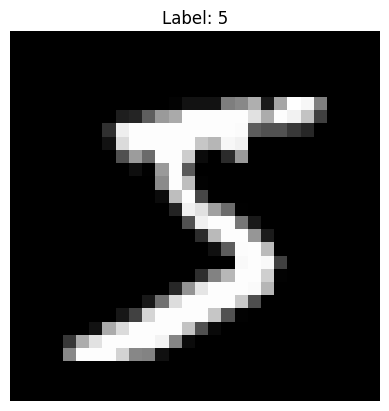

In [2]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()

In [4]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [6]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape and normalize
x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Build CNN model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(x_train, y_train_cat, batch_size=128, epochs=10, validation_data=(x_test, y_test_cat))


Epoch 1/10


2025-05-27 17:56:23.533433: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7701 - loss: 0.7053

2025-05-27 17:57:10.174366: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 99ms/step - accuracy: 0.7704 - loss: 0.7046 - val_accuracy: 0.9777 - val_loss: 0.0673
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 96ms/step - accuracy: 0.9607 - loss: 0.1295 - val_accuracy: 0.9849 - val_loss: 0.0455
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 102ms/step - accuracy: 0.9704 - loss: 0.0969 - val_accuracy: 0.9862 - val_loss: 0.0388
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 108ms/step - accuracy: 0.9770 - loss: 0.0766 - val_accuracy: 0.9870 - val_loss: 0.0354
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 103ms/step - accuracy: 0.9784 - loss: 0.0663 - val_accuracy: 0.9907 - val_loss: 0.0265
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 118ms/step - accuracy: 0.9818 - loss: 0.0585 - val_accuracy: 0.9902 - val_loss: 0.0278
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - accuracy: 0.9842 - loss: 0.0541 - val_accuracy: 0.9920 - val_loss: 0.0244
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9848 - loss: 0.0500 - val_ac

In [7]:
score = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test accuracy: {score[1]:.4f}")


2025-05-27 18:05:29.561079: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


Test accuracy: 0.9921


In [15]:
latent_dim = 100
num_classes = 10

from tensorflow.keras.layers import Concatenate

# Generator Input: noise + one-hot label
z_input = Input(shape=(latent_dim,))
label_input = Input(shape=(num_classes,))

combined_input = Concatenate()([z_input, label_input])

In [17]:
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, LeakyReLU, Conv2DTranspose

def build_conditional_generator():
    input_combined = Input(shape=(latent_dim + num_classes,))
    
    x = Dense(256)(input_combined)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Dense(7*7*128)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    x = Reshape((7, 7, 128))(x)
    
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(1, kernel_size=4, strides=2, padding='same', activation='sigmoid')(x)
    
    return Model(input_combined, x)

generator = build_conditional_generator()

In [18]:
model.trainable = False

In [19]:
gen_input_z = Input(shape=(latent_dim,))
gen_input_label = Input(shape=(num_classes,))
gen_input_combined = Concatenate()([gen_input_z, gen_input_label])

gen_output_img = generator(gen_input_combined)
classifier_output = model(gen_output_img)

cgan = Model([gen_input_z, gen_input_label], classifier_output)
cgan.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy')


In [20]:
import numpy as np
from tensorflow.keras.utils import to_categorical

for epoch in range(10000):
    # Sample random noise and labels
    z = np.random.normal(0, 1, (32, latent_dim))
    labels = np.random.randint(0, 10, 32)
    labels_onehot = to_categorical(labels, 10)

    # Train: generator tries to make classifier output correct digit
    loss = cgan.train_on_batch([z, labels_onehot], labels_onehot)

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.4f}")


Epoch 0 | Loss: 2.7241
Epoch 500 | Loss: 2.1341
Epoch 1000 | Loss: 1.3942
Epoch 1500 | Loss: 0.9716
Epoch 2000 | Loss: 0.7407
Epoch 2500 | Loss: 0.5989
Epoch 3000 | Loss: 0.5030
Epoch 3500 | Loss: 0.4334
Epoch 4000 | Loss: 0.3809
Epoch 4500 | Loss: 0.3403
Epoch 5000 | Loss: 0.3075
Epoch 5500 | Loss: 0.2801
Epoch 6000 | Loss: 0.2576
Epoch 6500 | Loss: 0.2384
Epoch 7000 | Loss: 0.2219
Epoch 7500 | Loss: 0.2075
Epoch 8000 | Loss: 0.1949
Epoch 8500 | Loss: 0.1837
Epoch 9000 | Loss: 0.1738
Epoch 9500 | Loss: 0.1648


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


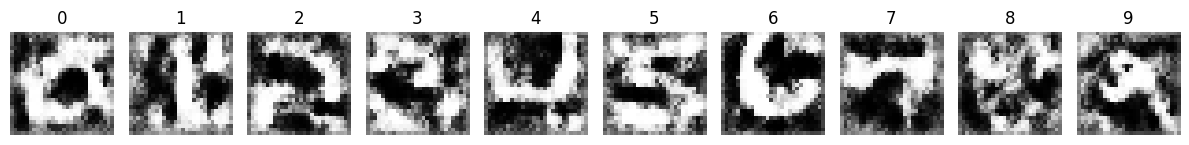

In [25]:
z = np.random.normal(0, 1, (10, latent_dim))
labels = np.arange(10)
labels_onehot = to_categorical(labels, 10)

generated_imgs = generator.predict(np.concatenate([z, labels_onehot], axis=1))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(generated_imgs[i].squeeze(), cmap='gray')
    plt.title(f"{i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# Generate a test batch of digits
latent_dim = 100
num_classes = 10
n = 1000  # number of samples

# Random noise + known labels
z = np.random.normal(0, 1, (n, latent_dim))
true_labels = np.random.randint(0, num_classes, n)
true_labels_onehot = to_categorical(true_labels, num_classes)

# Generate fake images
gen_input = np.concatenate([z, true_labels_onehot], axis=1)
fake_images = generator.predict(gen_input)

# Pass fake images into the frozen classifier
predictions = model.predict(fake_images)
predicted_labels = np.argmax(predictions, axis=1)

# Compare with the conditioned label
accuracy = np.mean(predicted_labels == true_labels)
print(f"Generator fooling accuracy (classifier agrees with intended label): {accuracy:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Generator fooling accuracy (classifier agrees with intended label): 1.0000
